**This Notebook is based on the Seurat vignettes**

In [ ]:
# Define the URL to download
file_url <- "https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"

# Define the file name for saving
file_name <- basename(file_url)

# Download the file
download.file(file_url, file_name)

# Unzip the downloaded file
untar(file_name)


In [ ]:
list.files("/content/filtered_gene_bc_matrices/hg19/")

[1] "barcodes.tsv" "genes.tsv"    "matrix.mtx"

In [ ]:
install.packages("Seurat")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘dotCall64’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘sp’, ‘spam’, ‘globals’, ‘listenv’, ‘parallelly’, ‘cpp11’, ‘zoo’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘spatstat.data’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘abind’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘SeuratObject’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘Rcpp’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘shiny’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’






---
**1- Import data**

In [ ]:
library(dplyr)
library(Seurat)
library(patchwork)
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/content/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)
 1 layer present: counts

In [ ]:
# Examine a few genes in the first thirty cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .



---


**2- QC and selecting cells**

The number of unique genes detected in each cell.
Low-quality cells or empty droplets will often have very few genes
Cell doublets or multiplets may exhibit an aberrantly high gene count
Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
The percentage of reads that map to the mitochondrial genome
Low-quality / dying cells often exhibit extensive mitochondrial contamination
We calculate mitochondrial QC metrics with the PercentageFeatureSet() function, which calculates the percentage of counts originating from a set of features
We use the set of all genes starting with MT- as a set of mitochondrial genes

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


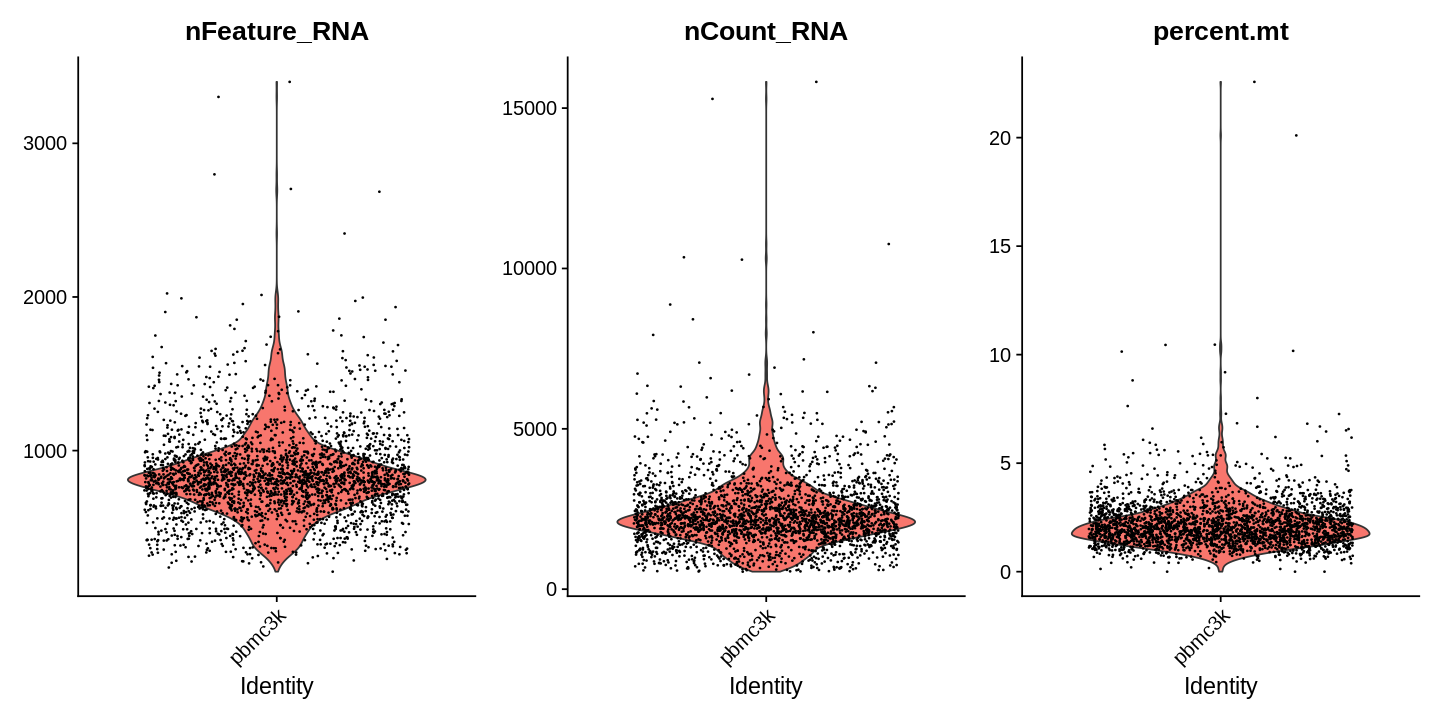

In [22]:
# Set the plot size
options(repr.plot.width = 12, repr.plot.height = 6)
# Visualize QC metrics as a violin plot
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

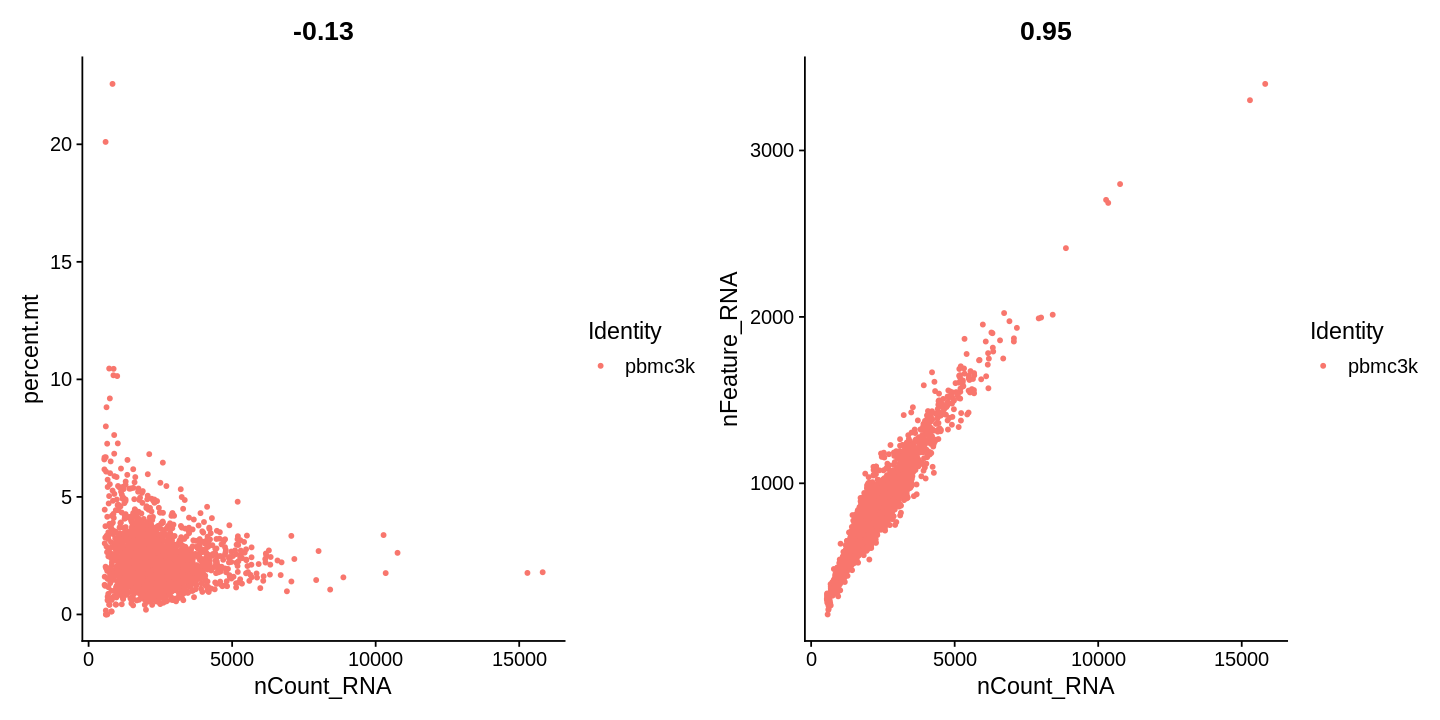

In [21]:
# Set the plot size
options(repr.plot.width = 12, repr.plot.height = 6)
# Visualize feature-feature relationships
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [24]:
# Filtering
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)



---

**3- Normalization**

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [25]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts





---

4- Feature selection

Calculate a subset of features that exhibit high cell-to-cell variation in the dataset.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”


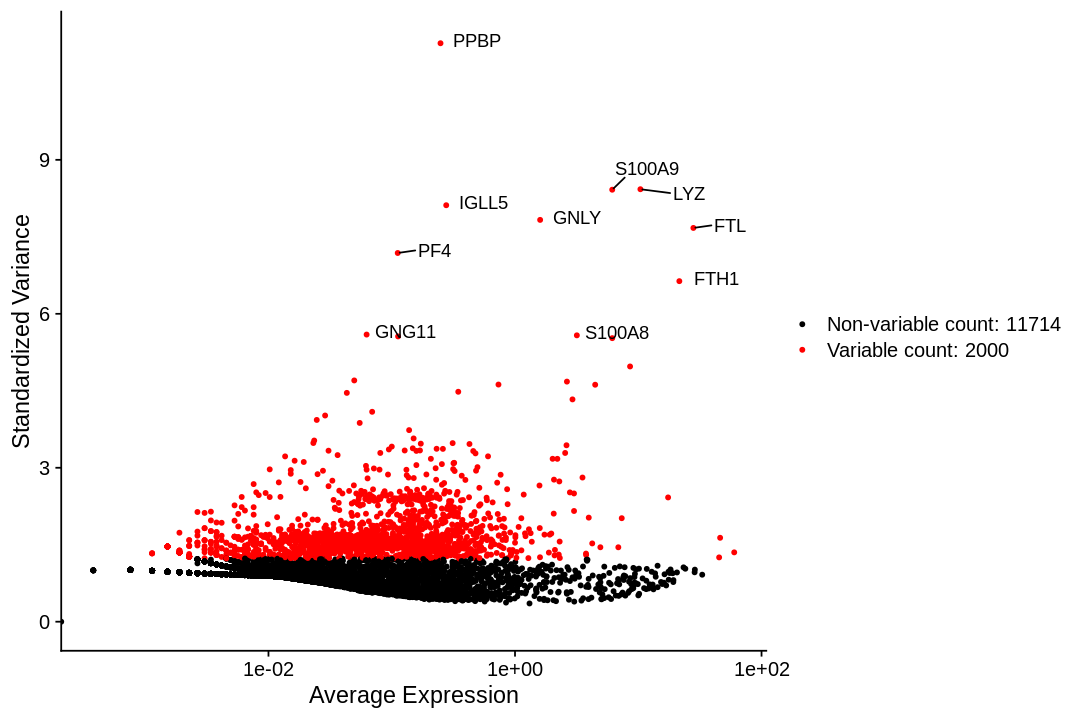

In [29]:
# Set the plot size
options(repr.plot.width = 9, repr.plot.height = 6)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2



---

**5- Dimensional reduction**

In [31]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [32]:
# Remove unwanted variations
pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


In [33]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, LGALS2, SERPINA1, S100A8, CTSS, IFITM3, SPI1, CFP 
	   PSAP, IFI30, COTL1, SAT1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CTSW, STK17A, CD27 
	   CD247, CCL5, GIMAP5, GZMA, AQP3, CST7, TRAF3IP3, SELL, GZMK, HOPX 
	   MAL, MYC, ITM2A, ETS1, LYAR, GIMAP7, KLRG1, NKG7, ZAP70, BEX2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, CTSC, APMAP, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1, HLA-DPB1, CD

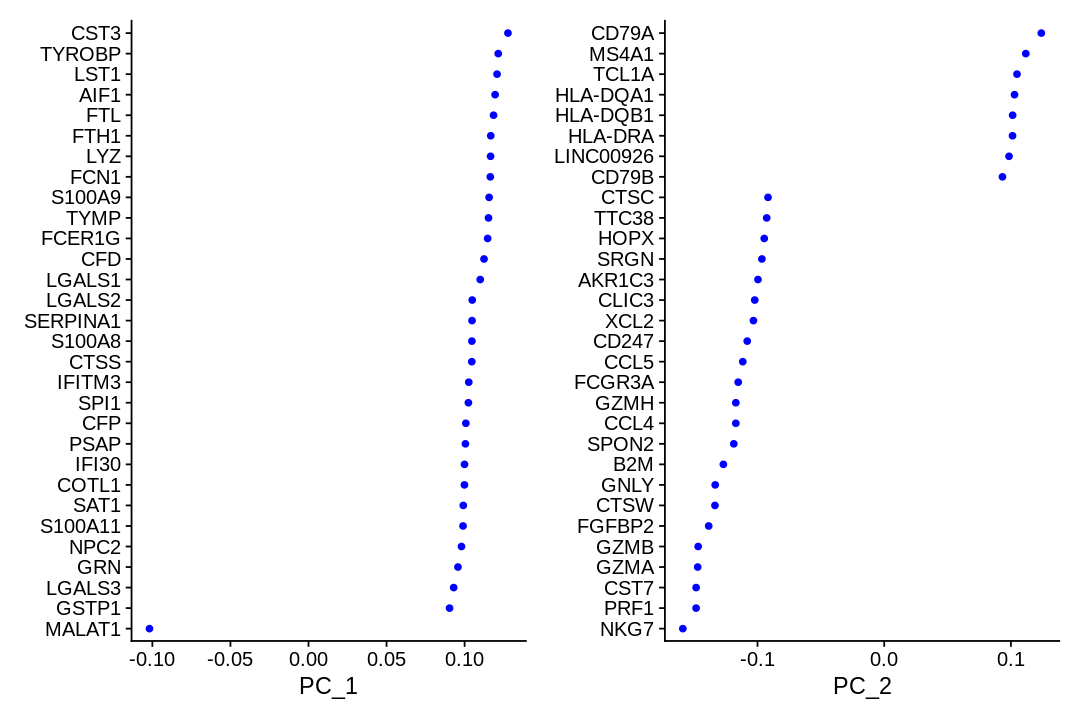

In [34]:
# Visualize PCA
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

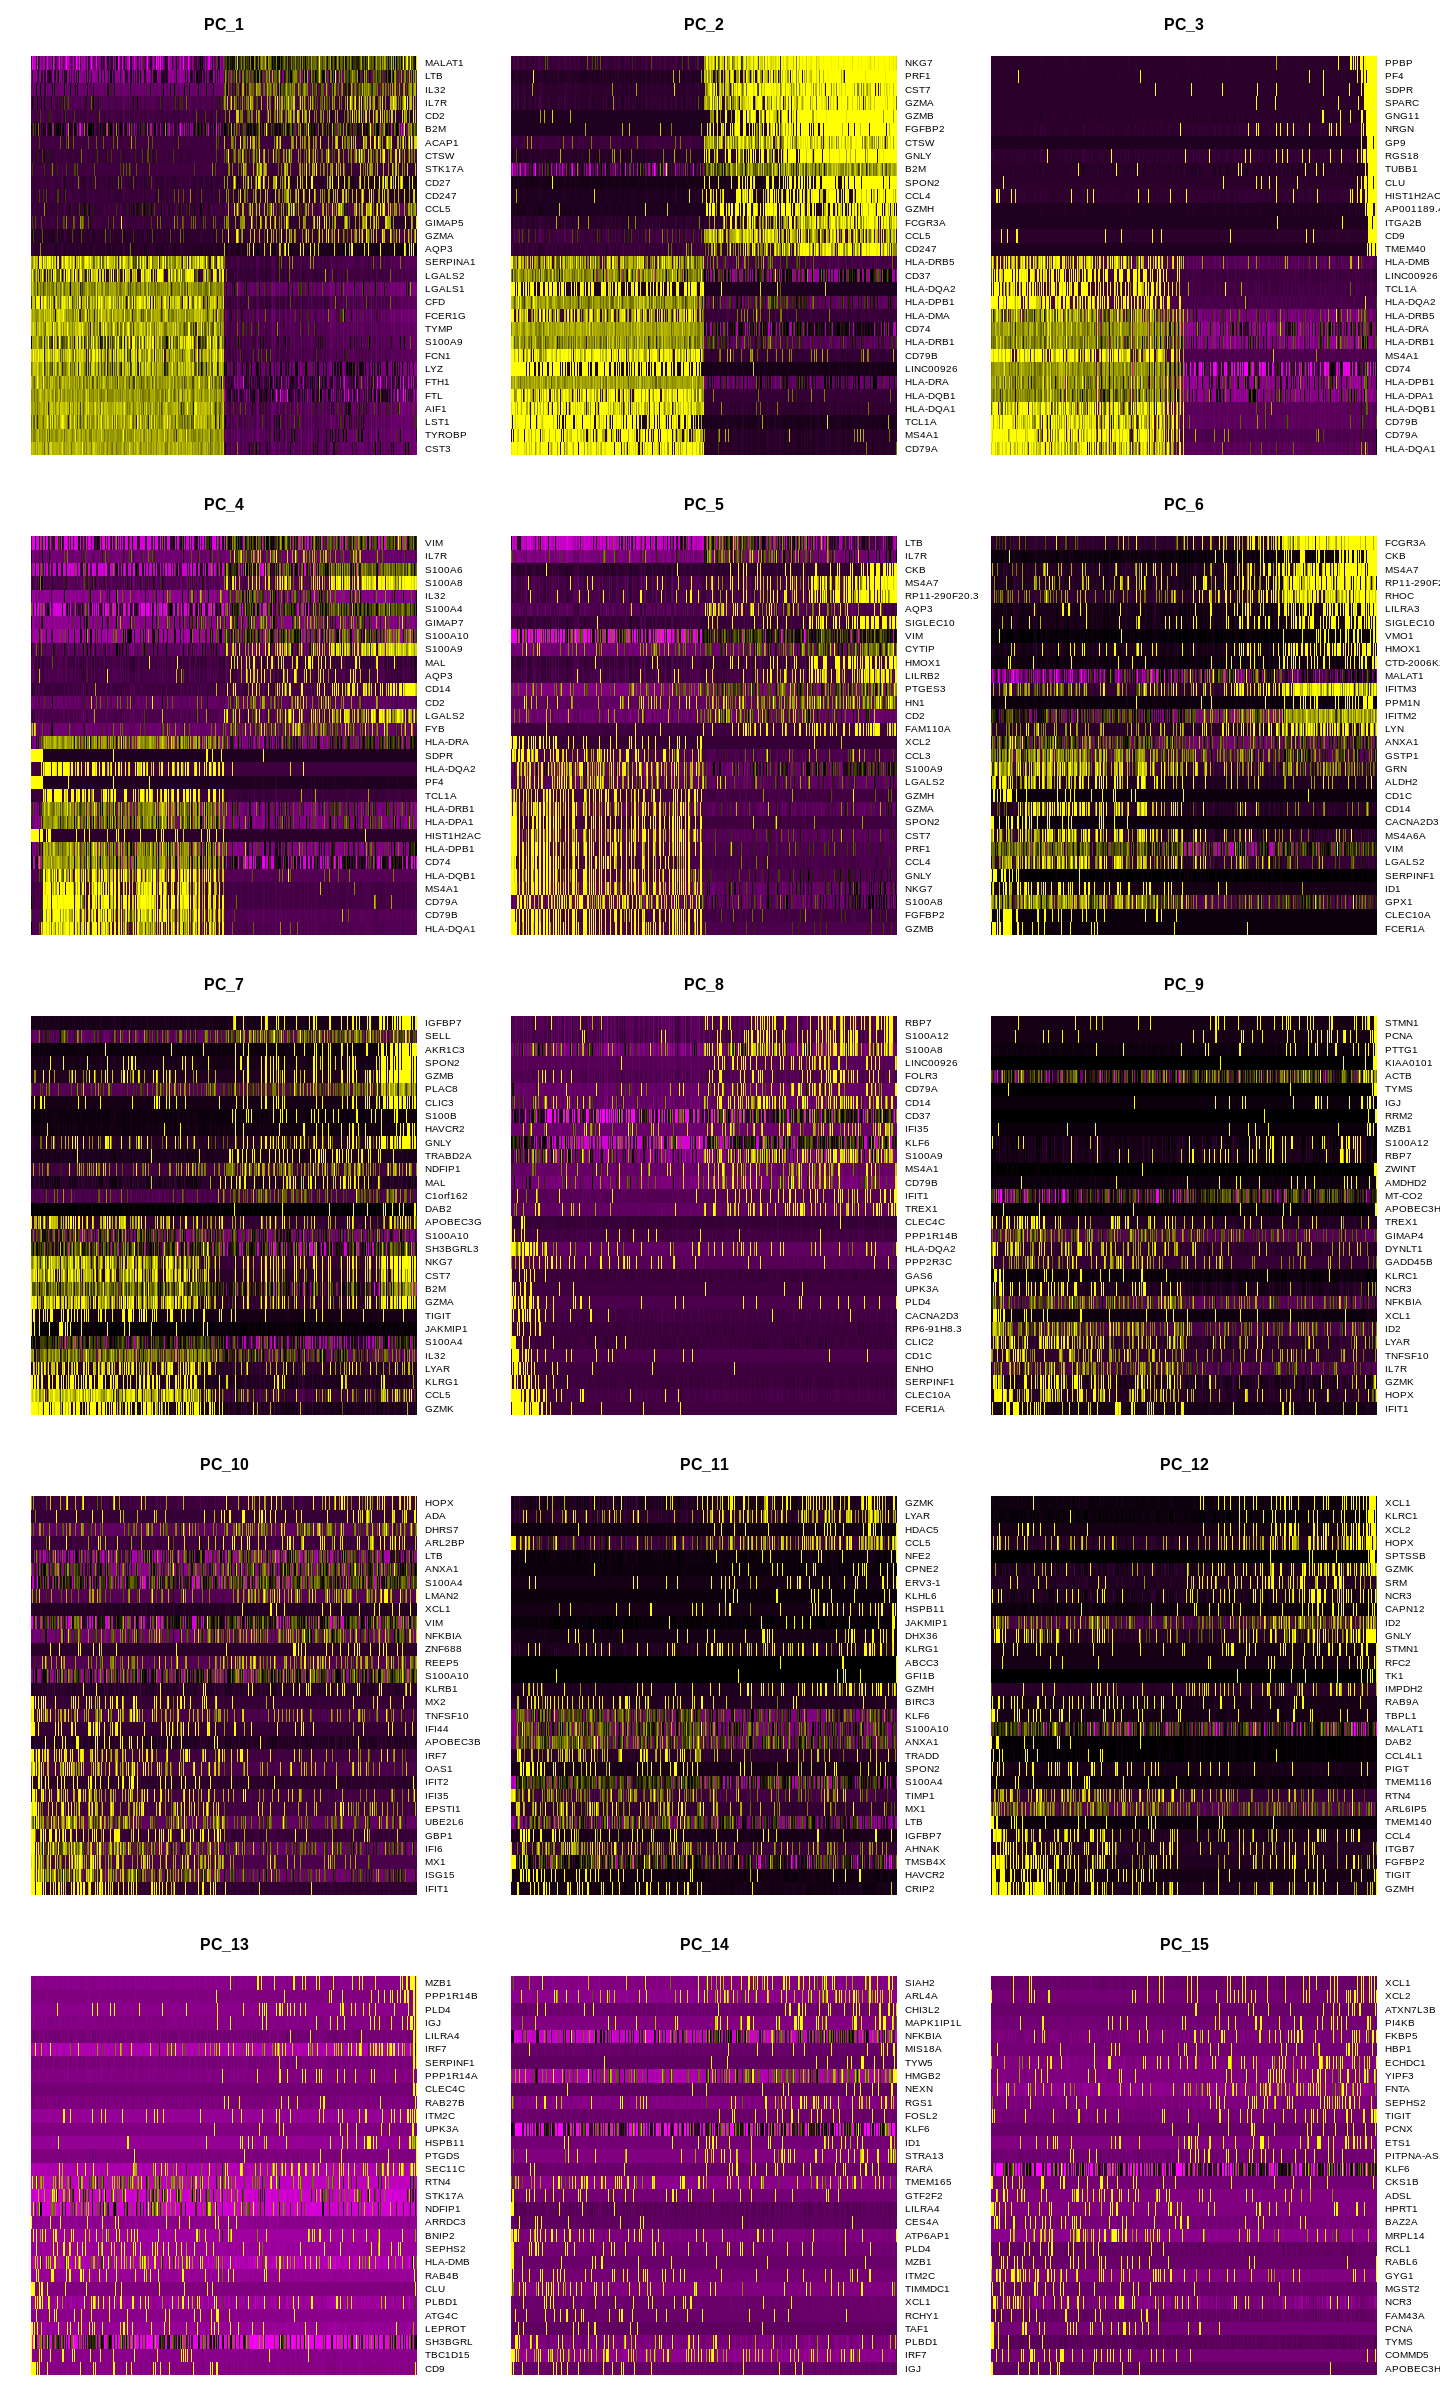

In [35]:
# Set the plot size
options(repr.plot.width = 12, repr.plot.height = 20)
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

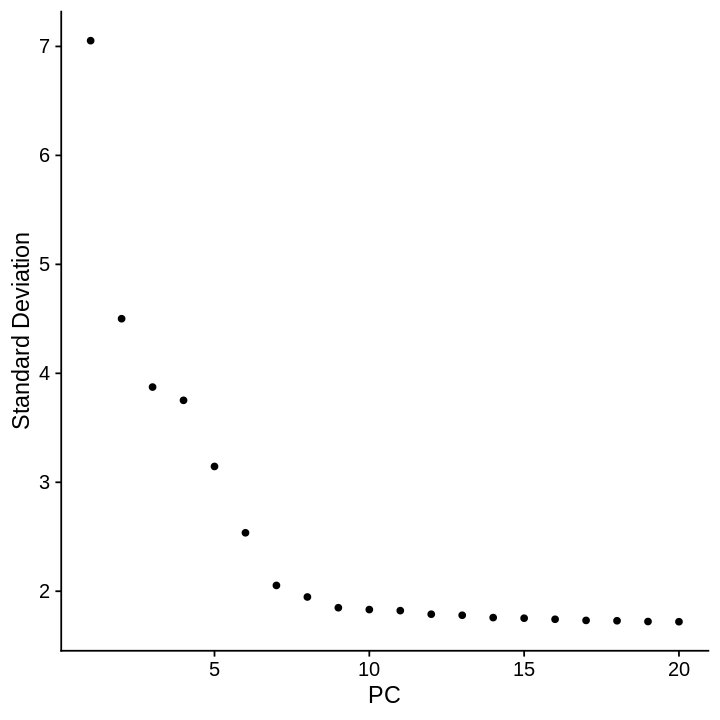

In [38]:
options(repr.plot.width = 6, repr.plot.height = 6)
# Assess the dimensionality of the dataset
ElbowPlot(pbmc)



---

**6- Cluster the cells**



In [39]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8735
Number of communities: 9
Elapsed time: 0 seconds


In [40]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               0                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

In [41]:
# Run UMAP
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:09:58 UMAP embedding parameters a = 0.9922 b = 1.112

13:09:58 Read 2638 rows and found 10 numeric columns

13:09:58 Using Annoy for neighbor search, n_neighbors = 30

13:09:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:09:59 Writing NN index file to temp file /tmp/Rtmp0Yi6q2/file249230d441a

13:09:59 Searching Annoy index using 1 thread, search_k = 3000

13:10:00 Annoy recall = 100%

13:10:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

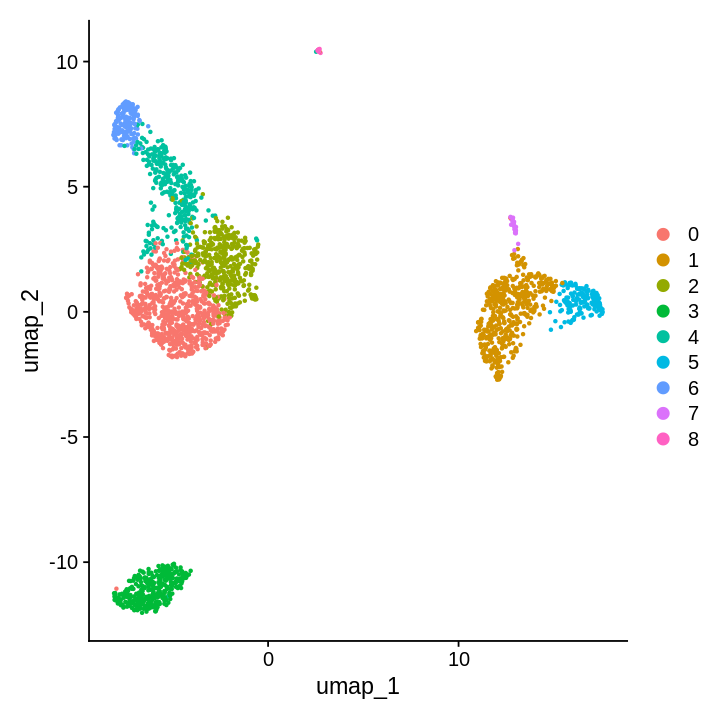

In [42]:
# individual clusters
DimPlot(pbmc, reduction = "umap")

In [43]:
saveRDS(pbmc, file = "/content/pbmc_tutorial.rds")



---

**7- Finding cluster biomarkers**

In [44]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2)
head(cluster2.markers, n = 5)

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,1.616287e-80,1.233523,0.951,0.475,2.216576e-76
LTB,1.931941e-80,1.333280,0.981,0.650,2.649464e-76
LDHB,5.248695e-65,1.035770,0.967,0.618,7.198060e-61
CD3D,1.379097e-61,0.992022,0.916,0.443,1.891293e-57
IL7R,7.116417e-60,1.404090,0.748,0.335,9.759454e-56


In [45]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3))
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,8.331882e-208,6.796878,0.975,0.040,1.142634e-203
CFD,1.932644e-198,6.141821,0.938,0.036,2.650429e-194
IFITM3,2.710023e-198,6.175520,0.975,0.049,3.716525e-194
CD68,1.069778e-193,5.487657,0.926,0.035,1.467094e-189
RP11-290F20.3,4.218926e-190,6.329921,0.840,0.016,5.785835e-186


In [46]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.877029e-117,1.200845,0.913,0.588,2.574157e-113,0,LDHB
5.014988e-85,2.387407,0.437,0.108,6.877554e-81,0,CCR7
2.635821e-83,1.129419,0.853,0.398,3.614765e-79,0,CD3D
1.424713e-56,1.029741,0.733,0.395,1.953851e-52,0,CD3E
2.045307e-49,2.090618,0.334,0.103,2.804934e-45,0,LEF1
2.329487e-48,1.223395,0.626,0.357,3.194659e-44,0,NOSIP
7.266337e-47,2.057672,0.334,0.108,9.965054e-43,0,PRKCQ-AS1
3.107278e-43,1.507967,0.436,0.184,4.261321e-39,0,PIK3IP1
1.238133e-42,2.796395,0.200,0.038,1.697975e-38,0,FHIT


In [ ]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)


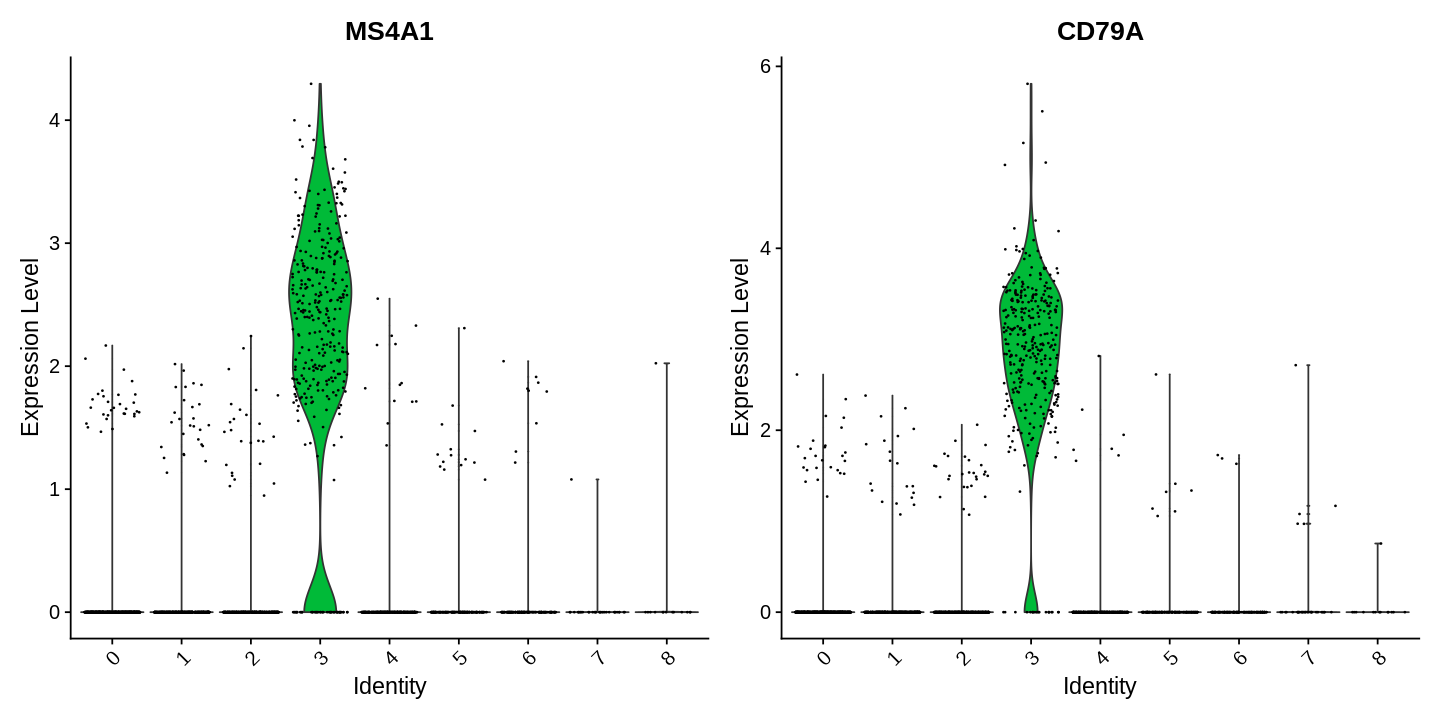

In [50]:
options(repr.plot.width = 12, repr.plot.height = 6)
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

Warning message:
“The `slot` argument of `VlnPlot()` is deprecated as of Seurat 5.0.0.
ℹ Please use the `layer` argument instead.”


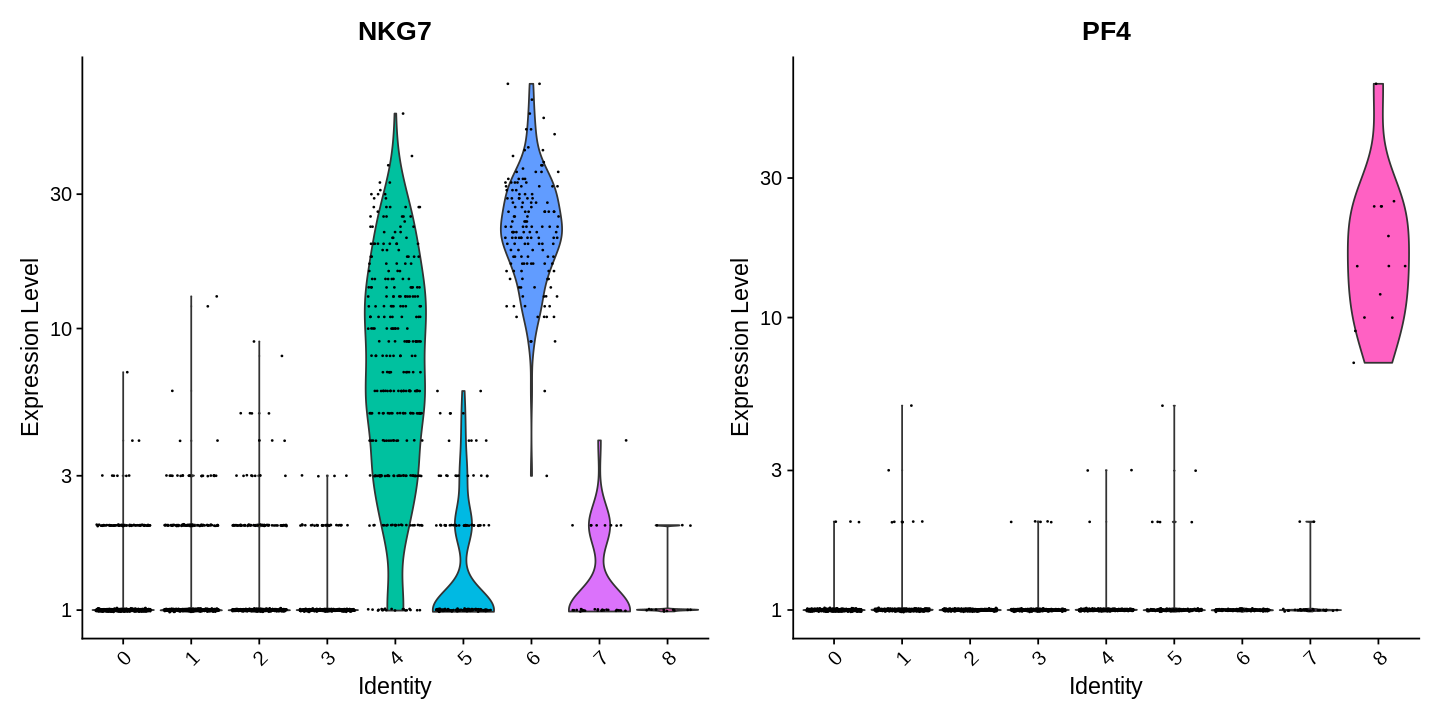

In [48]:
options(repr.plot.width = 12, repr.plot.height = 6)
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

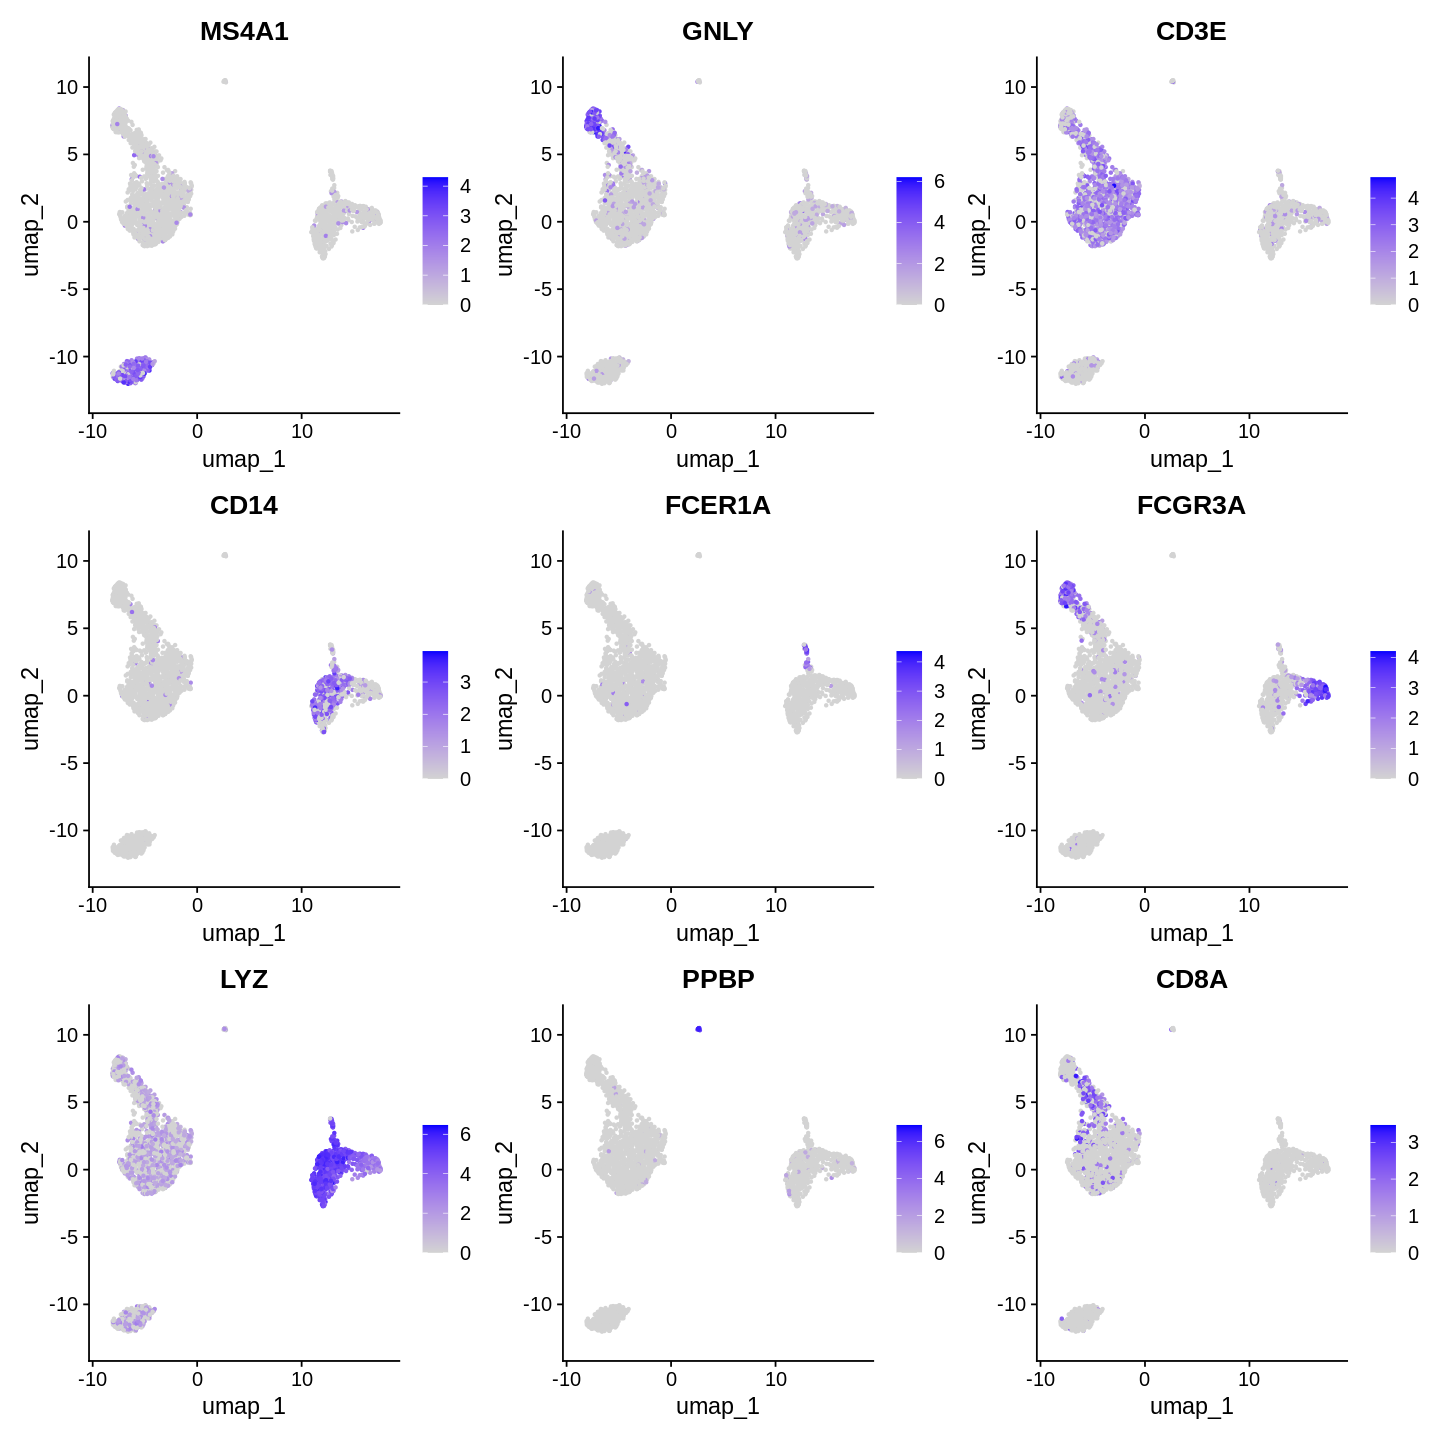

In [49]:
options(repr.plot.width = 12, repr.plot.height = 12)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

Warning message in DoHeatmap(pbmc, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: PKIB, KLRD1, PILRA, MS4A4A, HES4, CDKN1C, CD8A, VPREB3, CD40LG, TRAT1, TNFRSF4, FHIT, PIK3IP1, PRKCQ-AS1, NOSIP, LEF1, CD3E, CD3D, CCR7, LDHB”


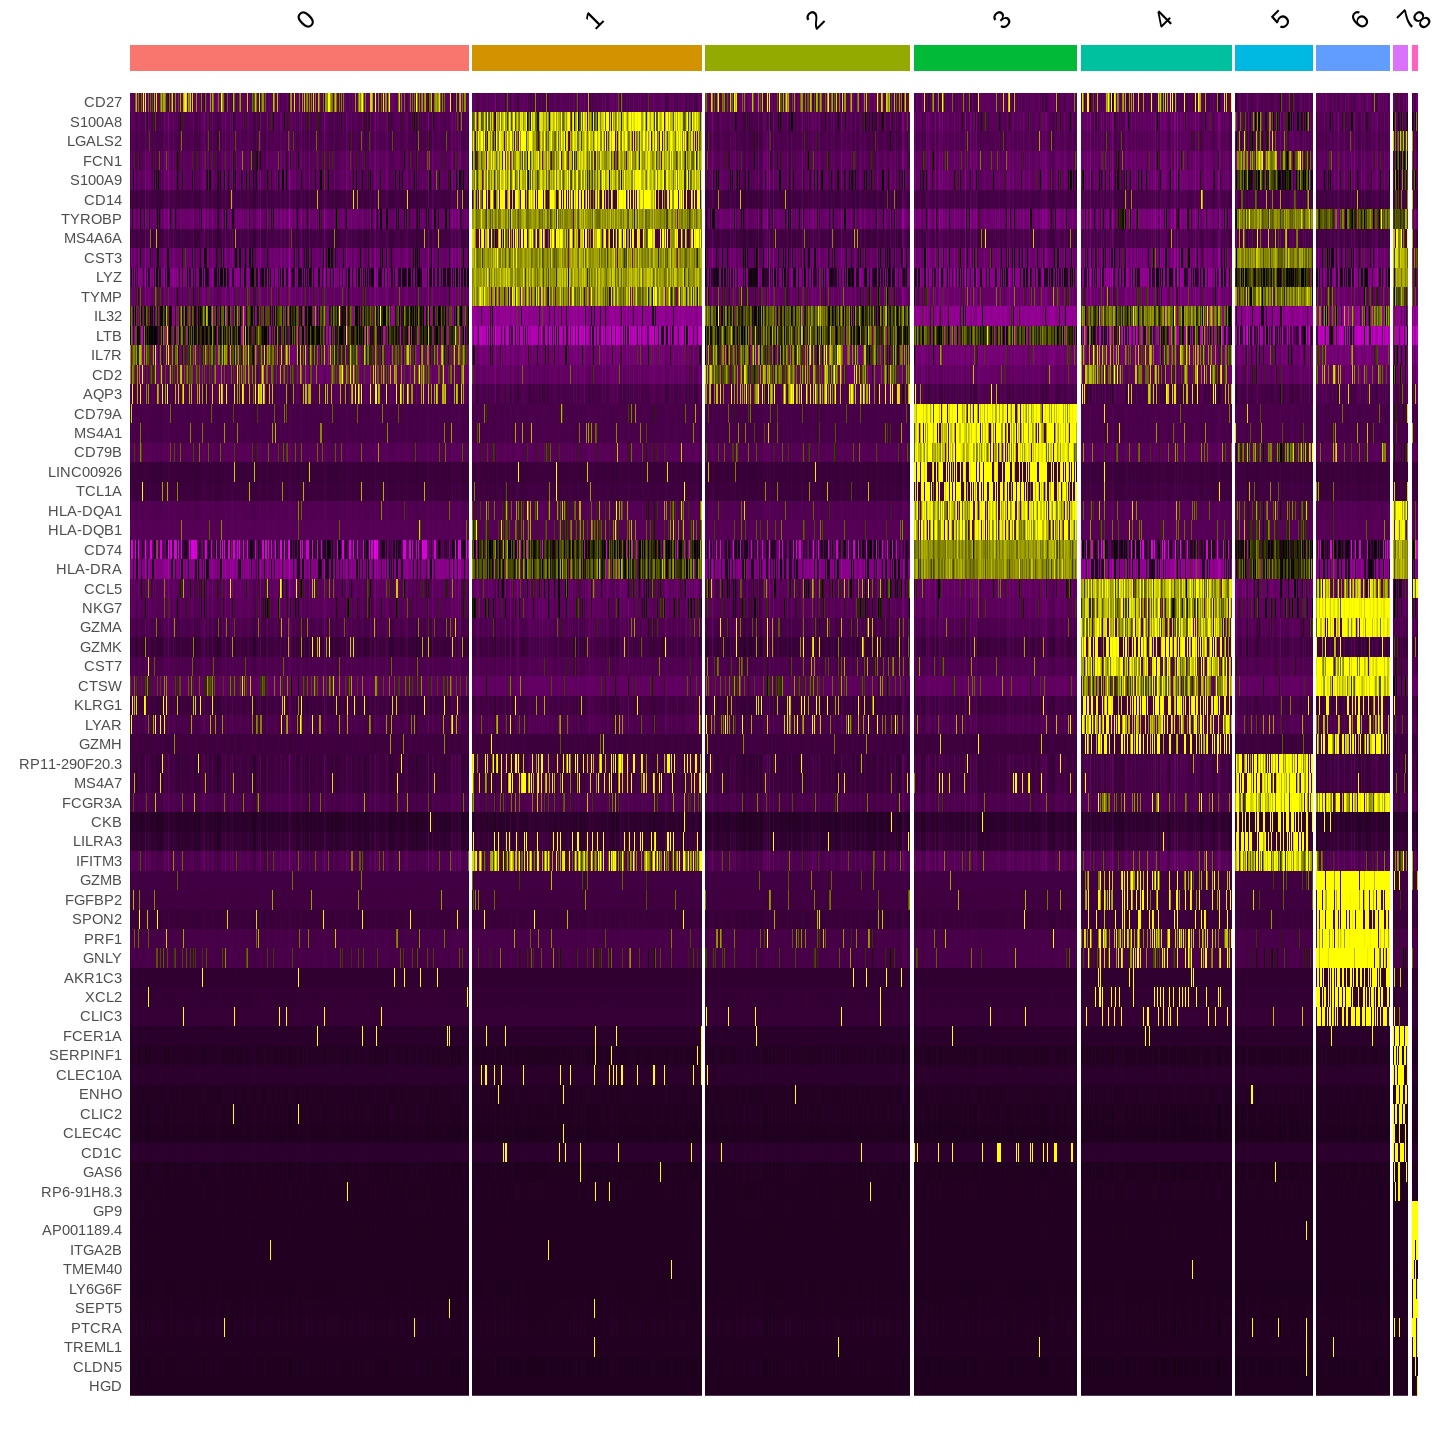

In [51]:
options(repr.plot.width = 12, repr.plot.height = 12)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()



---

**8- Assigning cell type identity to clusters**

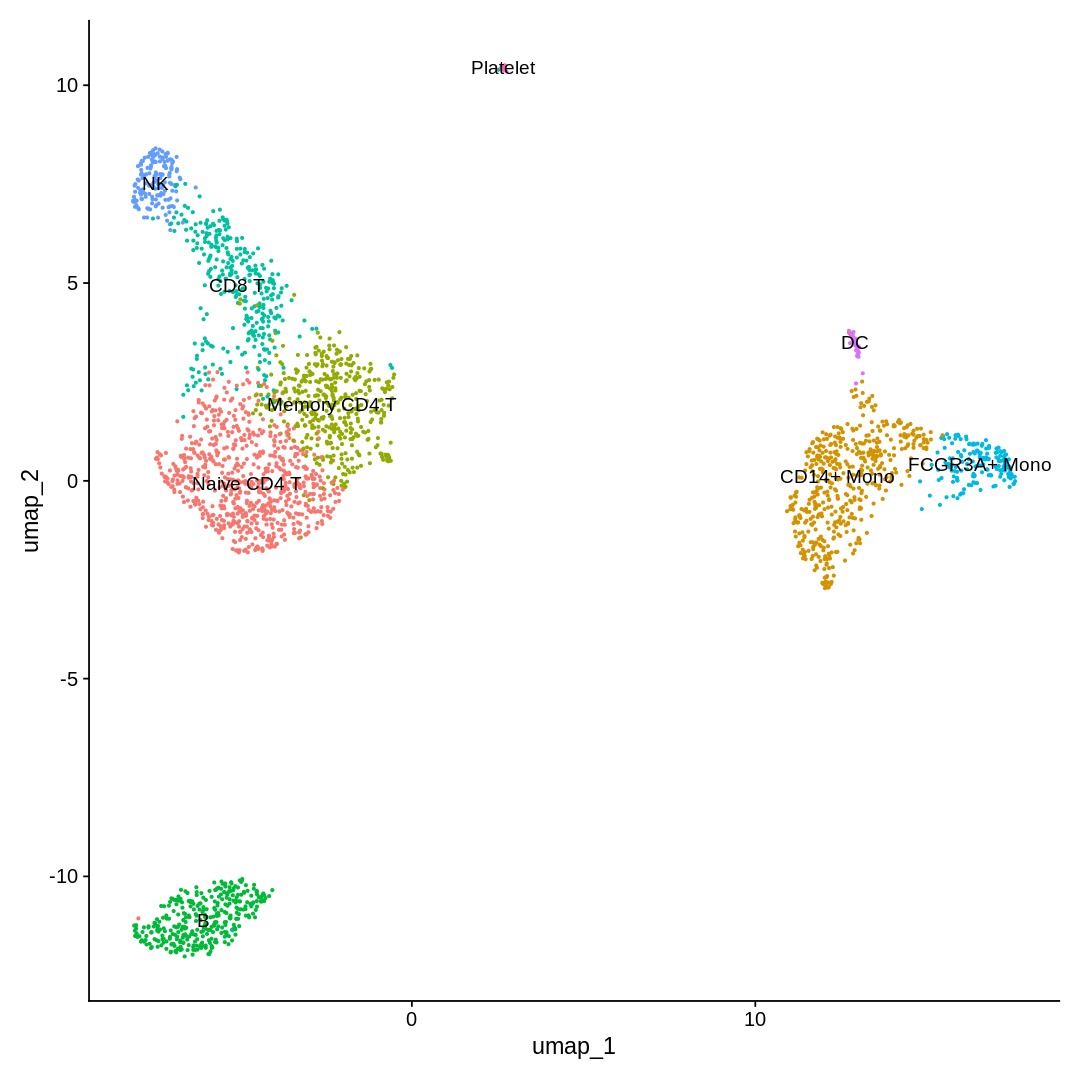

In [52]:
options(repr.plot.width = 9, repr.plot.height = 9)
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono",
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

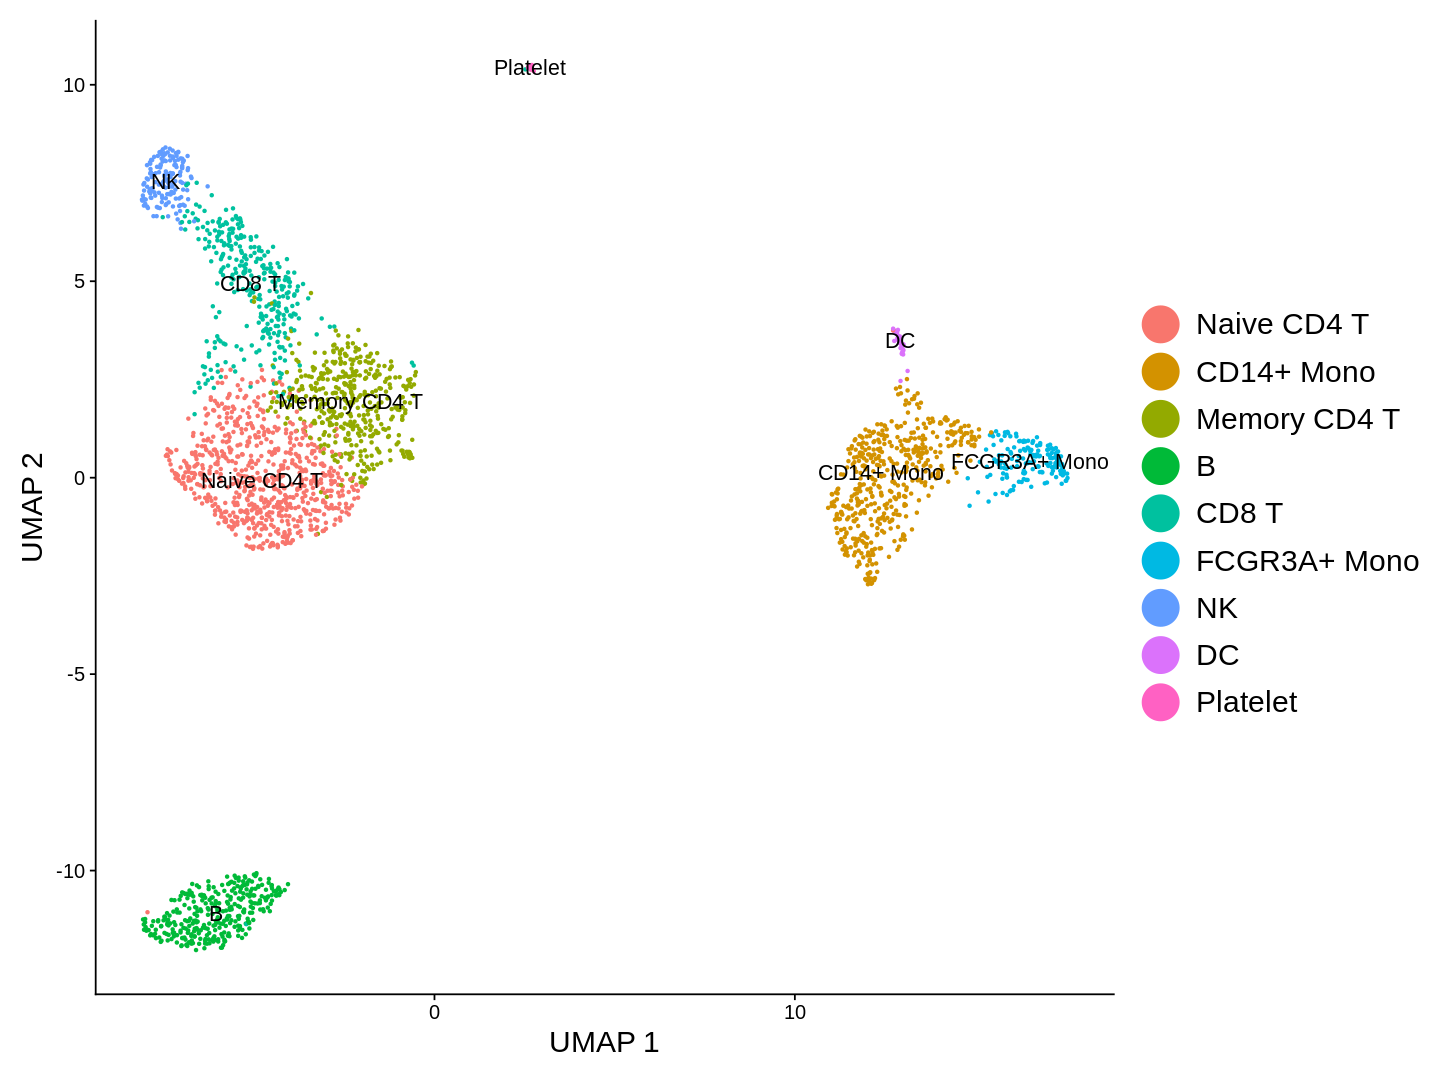

In [55]:
library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 9)
plot <- DimPlot(pbmc, reduction = "umap", label = TRUE, label.size = 4.5) + xlab("UMAP 1") + ylab("UMAP 2") +
    theme(axis.title = element_text(size = 18), legend.text = element_text(size = 18)) + guides(colour = guide_legend(override.aes = list(size = 10)))
plot

In [56]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.4      patchwork_1.1.3    Seurat_5.0.1       SeuratObject_5.0.1
[5] sp_2.1-2           dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1